# SQL to MongoDB

We will see how to model SQL data into MongoDB collections. We will use the same PostgreSQL database on which we worked on in the previous lessons, that is the Yelp database.

As for PostgreSQL, we need to use a library that provides an interface with MongoDB. This is PyMongo: it is a Python library containing tools for working with MongoDB, and is the recommended way to work with MongoDB from Python.

Then, now we import the mentioned and other well known libraries.

In [138]:
import pandas as pd
import datetime
import pymongo
import psycopg2

## Getting data from the Yelp SQL database

For building MongoDB collections, we need to get the data from the Postgres SQL Yelp database.

We connect to the database using the ``connect()`` function from ``psycopg2`` library avoiding, for sake of simplicity, the exception handling statements we used in the previous lessons.

When you are running this script, recall to call the ``connect()`` function with your login data.

In [139]:
connection = psycopg2.connect(user = "matteobodini",
                              password = "",
                              host = "localhost",
                              port = "5432",
                              database = "yelp")

With the below queries, we simply take some data of the businesses available in the Yelp database. We do the same for the reviewers' data.

Even here, we avoid to use the ad hoc function we built the last lesson and we use ``read_sql_query()`` from Pandas library.

Recall that the LEFT JOIN returns all the records from the left table, and the matched records from the right table. The result is NULL from the right side, if there is no match.

In [140]:
business_data = pd.read_sql_query("""SELECT business.id, business.name, city.name AS city_name, country, stars, is_active
                                     FROM business LEFT JOIN city ON business.city = city.id;""", connection)
reviewer_data = pd.read_sql_query("SELECT reviewer.id, reviewer.name, yelp_since FROM reviewer;", connection)

We see here below some records of the obtained dataframes.

In [141]:
business_data.head(10)

,id,name,city_name,country,stars,is_active
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,Ahwatukee,AZ,4.0,True
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,McMurray,PA,3.0,True
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,Phoenix,AZ,1.5,True
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,Tempe,AZ,3.0,False
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,Cuyahoga Falls,OH,3.5,True
5,o9eMRCWt5PkpLDE0gOPtcQ,Messina,Stuttgart,BW,4.0,True
6,kCoE3jvEtg6UVz5SOD3GVw,BDJ Realty,Las Vegas,NV,4.0,True
7,OD2hnuuTJI9uotcKycxg1A,Soccer Zone,Las Vegas,NV,1.5,True
8,EsMcGiZaQuG1OOvL9iUFug,Any Given Sundae,Wexford,PA,5.0,True
9,TGWhGNusxyMaA4kQVBNeew,Detailing Gone Mobile,Henderson,NV,5.0,True


In [142]:
business_data.shape

(174567, 6)

In [143]:
reviewer_data.head(10)

,id,name,yelp_since
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,2013-09-24
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,2017-03-02
2,mBneaEEH5EMyxaVyqS-72A,Mark,2015-03-13
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,2016-09-08
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,2012-07-16
5,Ob-2oGBQ7rwwYwUvhmnf7g,B,2012-05-01
6,JaTVvKsBl0bHHJEpESn4pQ,Peter,2013-03-23
7,Ykj0DVsz0c6rX9ghjd0hDg,Colleen,2010-10-10
8,kmyEPfKnHQJdTceCdoyMQg,A,2012-10-16
9,H54pA7YHfjl8IjhHAfdXJA,Chad,2010-06-25


In [144]:
reviewer_data.shape

(1326100, 3)

## Creation of the MongoDB collections

We create two collections with the aim of inserting them into the mongoDB database.

## Creation of the businesses collection

The first collection we create is the businesses one. We will insert the data we stored in the ``business_data`` dataframe. Further, we will insert in the collection the categories and the reviews left by the online users, associated with the business itself.

We create a utility variable for setting the number of items to store in each collection.

In [145]:
collection_size = 200

We even create two utility functions. The ``get_business_categories`` function takes as argument the id of the business and it returns the categories associated to the considered business. The ``get_business_reviews`` function even takes the id of the business and it returns some information related to the reviews associated to business itself.

In [146]:
def get_business_categories(business_id):
    
    table_data = pd.read_sql("SELECT category FROM incat WHERE business = '" + str(business_id) + "';", connection)

    categories = []
    for c in table_data.itertuples():
        categories.append(c.category)

    return categories

def get_business_reviews(business_id):

    table_data = pd.read_sql("""SELECT reviewer, name, yelp_since, review_date, stars
                                FROM review INNER JOIN reviewer ON review.reviewer = reviewer.id
                                WHERE business = '""" + str(business_id) + "';", connection)

    reviews = []
    for r in table_data.itertuples():
        record = {}
        if(r.reviewer) : record['reviewer_id'] = r.reviewer
        if(r.name) : record['reviewer_name'] = r.name
        if(r.yelp_since) : record['yelp_since'] = datetime.datetime.strptime(str(r.yelp_since), '%Y-%m-%d')
        if(r.review_date) : record['review_date'] = datetime.datetime.strptime(str(r.review_date), '%Y-%m-%d')
        if(r.stars) : record['review_score'] = int(r.stars)
        reviews.append(record)

    return reviews

We use ```pymongo.MongoClient()``` to get a Database instance. If the database is not created yet, the function will create a database which name is provided as argument into a list. We name it 'businesses'. 

With the ``iterrows`` method we can iterate between the rows of the business dataframe.

We take some information of thew business and we use the two previously defined functions ``get_business_categories`` and ``get_business_reviews`` to get the categories and the reviews associated to the business.

Step by step, we build a dictionary in the variable ``business`` and at the end of any loop iteration we insert the dictionary in the business collection. We break the loop when we reach the previously defined limit.

In [148]:
mdb = pymongo.MongoClient()['businesses']

for (i, b) in business_data.iterrows() :
    business = {}
    if(b.id) : business['id'] = b.id
    if(b.name) : business['name'] = b.name
    if(b.city_name) : business['city'] = b.city_name
    if(b.country) : business['country'] = b.country
    if(b.stars) : business['stars'] = int(b.stars)
    if(b.is_active) : business['is_active'] = bool(b.is_active)
    category_list = get_business_categories(b.id)
    if category_list:
        business['categories'] = category_list
    review_list = get_business_reviews(b.id)
    if review_list:
        business['reviews'] = review_list
    
    mdb['businesses'].insert_one(business)
                    
    if i >= collection_size : break

Let's see if the data were correctly stored performing a basic query. For instance, let's print the id of the stored businesses.

In [149]:
cursor = mdb['businesses'].find({})
for record in cursor.limit(10):
    print(record["id"])

FYWN1wneV18bWNgQjJ2GNg
He-G7vWjzVUysIKrfNbPUQ
KQPW8lFf1y5BT2MxiSZ3QA
8DShNS-LuFqpEWIp0HxijA
PfOCPjBrlQAnz__NXj9h_w
o9eMRCWt5PkpLDE0gOPtcQ
kCoE3jvEtg6UVz5SOD3GVw
OD2hnuuTJI9uotcKycxg1A
EsMcGiZaQuG1OOvL9iUFug
TGWhGNusxyMaA4kQVBNeew


Let's even find the first stored entry with the ``find_one()`` method.

In [150]:
mdb['businesses'].find_one()

{'_id': ObjectId('5edf46601bca82ff74bb96ef'),
 'id': 'FYWN1wneV18bWNgQjJ2GNg',
 'city': 'Ahwatukee',
 'country': 'AZ',
 'stars': 4,
 'is_active': True,
 'categories': ['Dentists',
  'Health & Medical',
  'General Dentistry',
  'Oral Surgeons',
  'Orthodontists',
  'Cosmetic Dentists'],
 'reviews': [{'reviewer_id': 'MWxrPSz87wx559-Rg3YL-Q',
   'reviewer_name': 'Jessica',
   'yelp_since': datetime.datetime(2012, 1, 9, 0, 0),
   'review_date': datetime.datetime(2013, 3, 12, 0, 0),
   'review_score': 1},
  {'reviewer_id': 'O412lFp-8M8VpRwdzl0S0A',
   'reviewer_name': 'Christina',
   'yelp_since': datetime.datetime(2014, 4, 21, 0, 0),
   'review_date': datetime.datetime(2014, 4, 21, 0, 0),
   'review_score': 5},
  {'reviewer_id': '4ZR5wwn8NST5aqCa3ueTFg',
   'reviewer_name': 'F.',
   'yelp_since': datetime.datetime(2012, 11, 19, 0, 0),
   'review_date': datetime.datetime(2014, 6, 28, 0, 0),
   'review_score': 1},
  {'reviewer_id': '9G8nsgZ-7o3an9HN4N08Hw',
   'reviewer_name': 'Lisa',
   'ye

## Creation of the reviewers collection

Let's now create the reviewers collection. We will insert the data we stored in the ``reviewer_data`` dataframe. Further, we will insert in the collection the friends associated to the current reviewer.

As before, we write for the sake of simplicity, a function to get the friends of a reviewer.

In [151]:
def get_reviewer_friends(reviewer_id):

    table_data = pd.read_sql("""SELECT id, name, yelp_since
                                FROM friend INNER JOIN reviewer ON reviewer_b = reviewer.id
                                WHERE reviewer_a = '""" + str(reviewer_id) + "'" +
                                """UNION (SELECT id, name, yelp_since 
                                          FROM friend INNER JOIN reviewer ON reviewer_a = reviewer.id
                                          WHERE reviewer_b = '""" + str(reviewer_id) + "');", connection)
            
    friends = []
    if table_data is not None:
        for f in table_data.itertuples():
            record = {}
            if(f.id) : record['reviewer_id'] = f.id
            if(f.name) : record['reviewer_name'] = f.name
            if(f.yelp_since) : record['yelp_since'] = datetime.datetime.strptime(str(f.yelp_since), '%Y-%m-%d')
            friends.append(record)

    return friends

In [153]:
mdb = pymongo.MongoClient()['reviewers']

for (i, r) in reviewer_data.iterrows() :
    reviewer = {}
    if(r.id) : reviewer['id'] = r.id
    if(r.name) : reviewer['name'] = r.name
    if(r.yelp_since) : reviewer['yelp_since'] = datetime.datetime.strptime(str(r.yelp_since), '%Y-%m-%d')
    friend_list = get_reviewer_friends(r.id)
    if friend_list:
        reviewer['friends'] = friend_list
    
    mdb['reviewers'].insert_one(reviewer)
                    
    if i >= collection_size : break

Let's see if the data were correctly stored performing a basic query. For instance, let's print the id of the stored reviewers.

In [154]:
cursor = mdb['reviewers'].find({})
for record in cursor.limit(10):
    print(record["id"])

JJ-aSuM4pCFPdkfoZ34q0Q
uUzsFQn_6cXDh6rPNGbIFA
mBneaEEH5EMyxaVyqS-72A
W5mJGs-dcDWRGEhAzUYtoA
4E8--zUZO1Rr1IBK4_83fg
Ob-2oGBQ7rwwYwUvhmnf7g
JaTVvKsBl0bHHJEpESn4pQ
Ykj0DVsz0c6rX9ghjd0hDg
kmyEPfKnHQJdTceCdoyMQg
H54pA7YHfjl8IjhHAfdXJA


Let's even find the first stored entry.

In [155]:
mdb['reviewers'].find_one()

{'_id': ObjectId('5edf47cf1bca82ff74bb97ba'),
 'id': 'JJ-aSuM4pCFPdkfoZ34q0Q',
 'yelp_since': datetime.datetime(2013, 9, 24, 0, 0),
 'friends': [{'reviewer_id': '7CghpxENlXnjTGOyNtRDsg',
   'reviewer_name': 'sarah',
   'yelp_since': datetime.datetime(2009, 11, 10, 0, 0)},
  {'reviewer_id': 'xtVcWcIKVORcBKhmdbrFiA',
   'reviewer_name': 'Trisa',
   'yelp_since': datetime.datetime(2010, 8, 22, 0, 0)},
  {'reviewer_id': 'Y-AnP_QFDcq6B9BoDUUs0A',
   'reviewer_name': 'Angie',
   'yelp_since': datetime.datetime(2010, 8, 27, 0, 0)},
  {'reviewer_id': 'XAWO5aDTxo-LTE4jVdBdVg',
   'reviewer_name': 'Mary',
   'yelp_since': datetime.datetime(2011, 1, 27, 0, 0)},
  {'reviewer_id': 'IWlU5scMqNaKSWO5ovY_iA',
   'reviewer_name': 'Brandi',
   'yelp_since': datetime.datetime(2010, 11, 28, 0, 0)},
  {'reviewer_id': '23lcgZUt6dvtMqV_AZe9KQ',
   'reviewer_name': 'Jennifer',
   'yelp_since': datetime.datetime(2010, 3, 15, 0, 0)},
  {'reviewer_id': 'loEGz0M-bBf0XnyjrbEvFQ',
   'reviewer_name': 'Andrea',
   '

# Data scraping and prediction

Imagine you need to create a database starting from data coming from a particular website. Is it possible to do so, without manually going to each web page and getting the data? Well yes, this is usually called “Web Scraping”.

Web Scraping consist in extracting large amounts of data from websites, whereby the data is extracted and saved in your computer or on a database (maybe on a MongoDB one). The data extracted from the web can serve a lot of different purposes like:

- Price comparison: Web Scraping can be used to track product and service prices in different markets over time.
- Social media scraping: Data from Social Media websites like Twitter can be collected by Web Scraping and used to find out what’s trending.
- Research and development: Web Scraping is used to collect large datasets like statistics, temperature, etc. from different websites, which are then used to carry out surveys.
- Extraction of contact information: Web Scraping can be used to scrape contact information such as emails, URLs, and phone numbers from websites.

Before we get into Web scraping, some important points-to-remember:

- Always read through the website’s Terms and Conditions to understand how you can legally use its data since most of the websites prohibit you from using the data for commercial purposes.
- Make sure you are not downloading the data at a rapid rate because this might break the website.

Here we import the libraries that we will use for Web Scraping:

- Selenium: a web testing library used to automate browser activities.
- BeautifulSoup: it is a Python package for parsing HTML and XML documents. It creates parse trees that are helpful for extracting data easily.
- Pandas.

In [121]:
from selenium import webdriver
from bs4 import BeautifulSoup

### Scraping the Flipkart Website

We are going scrape the Flipkart website (https://www.flipkart.com) to extract the price, name, user rating and features (tech specs) of many laptops.

The data on the website is nested in tags. So, we need to inspect the page to see under which tag the data we want to scrape is nested. To inspect web source in Safari on MacOS, just right click on the element and click on “Inspect”. Let's check the below link:

https://www.flipkart.com/laptops/pr?sid=6bo%2Fb5g&p%5B%5D=facets.serviceability%5B%5D%3Dtrue&wid=11.productCard.PMU_V2_10&page=1

Now, we now the div tags that we need.

Using ```webdriver.Safari()```, we allow the Python library ```selenium``` to use Safari. To do so, we provide as argument the path to ```safaridriver```.

In [162]:
driver = webdriver.Safari(executable_path = '/usr/bin/safaridriver')

We prepare lists for Prices, Names, Ratings and Features of the laptops.

In [163]:
products = []
prices = []
ratings = []
all_features = []

With the following for loop, we download all the 32 web pages containing laptops. 

For every page, we parse the html source inside to get all the html portions of code containing the info of the laptops.

Then, we parse the name, the price, the rating and the features, if they are available. If not, we save a ```Nan``` value.

Also, we perform same basic data manipulation (price conversion in euro, etc. Where $1€ \sim ₹78$ Indian rupees).

In [164]:
exchange = 78.0
for i in range(1,32) :
    driver.get("https://www.flipkart.com/laptops/pr?sid=6bo%2Fb5g&p%5B%5D=facets.serviceability%5B%5D%3Dtrue&wid=11.productCard.PMU_V2_10&page=" + str(i))
    content = driver.page_source
    soup = BeautifulSoup(content)
    features = []
    for a in soup.findAll('a', href=True, attrs={'class':'_31qSD5'}) :
        name = a.find('div', attrs={'class':'_3wU53n'})
        price = a.find('div', attrs={'class':'_1vC4OE _2rQ-NK'})
        rating = a.find('div', attrs={'class':'hGSR34'})        
        for f in a.findAll('li', attrs={'class':'tVe95H'}) :
            features.append(f.text)
        all_features.append(features)
        features = []
        products.append(name.text)
        prices.append(float((price.text).split("₹")[1].replace(',', ''))/exchange)
        if(rating is not None) :
            ratings.append(float(rating.text))
        else :
            ratings.append(float('nan'))

Now, we can simply create a pandas dataframe and we explore the data.

In [185]:
df = pd.DataFrame({'Product Name' : products, 'Price' : prices, 'Rating' : ratings, 'Features' : all_features})
df.head(20)

,Product Name,Price,Rating,Features
0,HP 15s Ryzen 5 Quad Core - (8 GB/512 GB SSD/Wi...,538.333333,4.5,"[AMD Ryzen 5 Quad Core Processor, 8 GB DDR4 RA..."
1,Dell Vostro 15 3000 Core i3 7th Gen - (4 GB/1 ...,352.435897,4.4,"[Intel Core i3 Processor (7th Gen), 4 GB DDR4 ..."
2,Lenovo Ideapad S145 Core i3 8th Gen - (8 GB/1 ...,474.230769,4.2,"[Intel Core i3 Processor (8th Gen), 8 GB DDR4 ..."
3,Lenovo Ideapad S145 Core i3 8th Gen - (4 GB/1 ...,410.128205,4.4,"[Intel Core i3 Processor (8th Gen), 4 GB DDR4 ..."
4,Lenovo Ideapad 130 Core i3 7th Gen - (4 GB/1 T...,384.487179,4.0,"[Intel Core i3 Processor (7th Gen), 4 GB DDR4 ..."
5,Asus VivoBook Gaming Core i5 8th Gen - (8 GB/5...,640.897436,NaN,"[Intel Core i5 Processor (8th Gen), 8 GB DDR4 ..."
6,Acer Aspire 7 Core i5 9th Gen - (8 GB/512 GB S...,705.000000,4.6,"[Intel Core i5 Processor (9th Gen), 8 GB DDR4 ..."
7,Asus VivoBook 15 Core i3 7th Gen - (4 GB/1 TB ...,358.846154,4.2,"[Intel Core i3 Processor (7th Gen), 4 GB DDR4 ..."
8,Lenovo Ideapad S145 Core i5 10th Gen - (8 GB/1...,640.897436,4.0,"[Intel Core i5 Processor (10th Gen), 8 GB DDR4..."
9,Asus VivoBook S Series Core i5 8th Gen - (8 GB...,640.897436,4.5,"[Intel Core i5 Processor (8th Gen), 8 GB DDR4 ..."


We can also plot the data, using ```seaborn```.

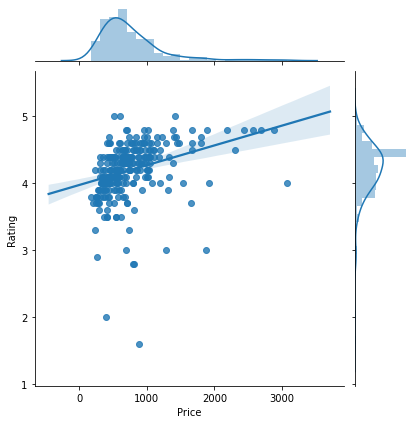

In [173]:
import seaborn as sns
sns.jointplot(x="Price", y="Rating", data=df, kind="reg");

Like before, we create a collection named 'laptops' and we insert it in a new mongodb database named 'computers'.

In [174]:
records = []
for i, row in df.iterrows():
    record = row
    records.append(dict(record))
records

[{'Product Name': 'HP 15s Ryzen 5 Quad Core - (8 GB/512 GB SSD/Windows 10 Home) 15s-EQ0024au Thin and Light Laptop',
  'Price': 538.3333333333334,
  'Rating': 4.5,
  'Features': ['AMD Ryzen 5 Quad Core Processor',
   '8 GB DDR4 RAM',
   '64 bit Windows 10 Operating System',
   '512 GB SSD',
   '39.62 cm (15.6 inch) Display',
   '1 Year Onsite Warranty']},
 {'Product Name': 'Dell Vostro 15 3000 Core i3 7th Gen - (4 GB/1 TB HDD/Linux) vos / vostro 3581 Laptop',
  'Price': 352.43589743589746,
  'Rating': 4.4,
  'Features': ['Intel Core i3 Processor (7th Gen)',
   '4 GB DDR4 RAM',
   'Linux/Ubuntu Operating System',
   '1 TB HDD',
   '39.62 cm (15.6 inch) Display',
   '1 Year Limited Hardware Warranty, In Home Service After Remote Diagnosis - Retail']},
 {'Product Name': 'Lenovo Ideapad S145 Core i3 8th Gen - (8 GB/1 TB HDD/Windows 10 Home) 81VD ideapad S145-15IKB U Laptop',
  'Price': 474.2307692307692,
  'Rating': 4.2,
  'Features': ['Intel Core i3 Processor (8th Gen)',
   '8 GB DDR4 RAM

In [176]:
mdb = pymongo.MongoClient()['computers']

In [177]:
mdb['laptops'].insert_many(records)

Then, we download again all the data and we drop ```NaN``` values. Further, we remove ```_id``` column, automatically generated by Mongo.

In [178]:
df2 = pd.DataFrame(list(mdb.laptops.find({})))
df2 = df2.drop(columns = ['_id'])
df2 = df2.dropna()
df2.shape

(2013, 4)

We can use ```sklearn``` to fit a least squares model. Then, we plot it.

rmse:  0.18052307365339793


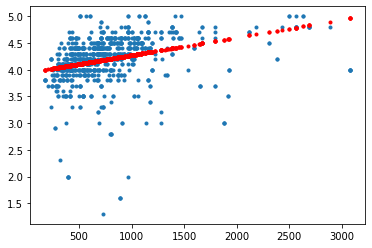

In [179]:
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

linearRegressor = linear_model.LinearRegression()
X = df2['Price']
X = np.array(X)
X = X.reshape(-1, 1)
y = df2['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
linearRegressor.fit(X_train, y_train)
y_pred = linearRegressor.predict(X_test)
plt.plot(X_test[:,0], y_test, '.');
plt.plot(X_test[:,0], y_pred, 'r.');
print("rmse: ", mean_squared_error(y_test, y_pred))

We can also remove some outliers and plotting again the data.

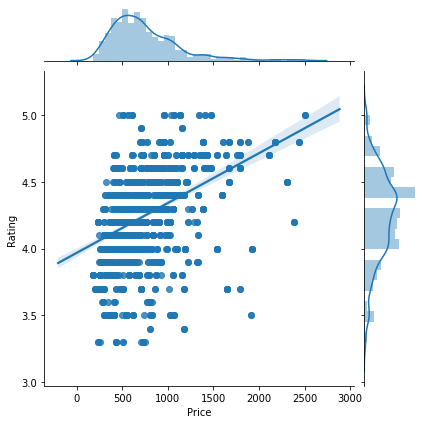

In [180]:
filteredDF = df2[(df2.Price < 2500) & (df2.Rating > 3.2)]
sns.jointplot(x="Price", y="Rating", data = filteredDF, kind="reg");

rmse:  0.093711845014368


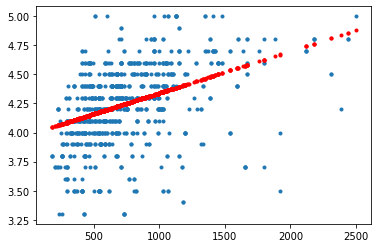

In [181]:
X = filteredDF['Price']
X = np.array(X)
X = X.reshape(-1, 1)
y = filteredDF['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
linearRegressor.fit(X_train, y_train)
y_pred = linearRegressor.predict(X_test)
plt.plot(X_test[:,0], y_test, '.');
plt.plot(X_test[:,0], y_pred, 'r.');
print("rmse: ", mean_squared_error(y_test, y_pred))

If we remove the outliers, we notice an improvement in performances.

Let's try also other models. We use a KNN for regression and we scale the data.

We recall how KNN works in case of regression: 

- First, the distance between the new point and each training point is calculated.
- The closest k data points are selected (based on the distance).
- The average of these data points is the final prediction for the new point. 

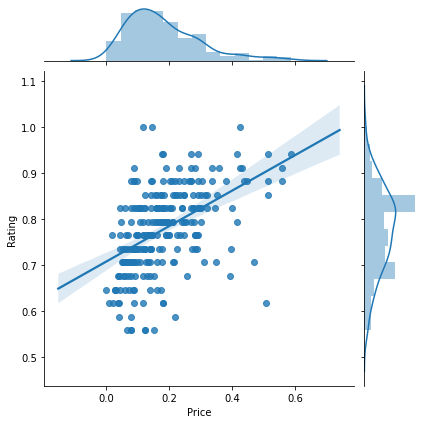

In [182]:
from sklearn import preprocessing

data = df[['Price', 'Rating']].dropna().values
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(data)
data_scaled
df3 = pd.DataFrame({'Price' : data_scaled[:,0], 'Rating' : data_scaled[:,1]})
filteredDF3 = df3[(df3.Price < 0.6) & (df3.Rating > 0.5)]
sns.jointplot(filteredDF3['Price'], filteredDF3['Rating'], kind='reg');

rmse:  0.006314287404252802


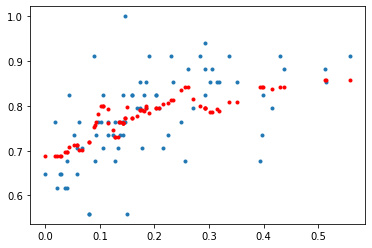

In [183]:
from sklearn.neighbors import KNeighborsRegressor
KNNreg = KNeighborsRegressor(n_neighbors=15)
X = filteredDF3['Price']
X = np.array(X)
X = X.reshape(-1, 1)
y = filteredDF3['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
KNNreg.fit(X_train, y_train)
y_pred = KNNreg.predict(X_test)
plt.plot(X_test[:,0], y_test, '.');
plt.plot(X_test[:,0], y_pred, 'r.');
print("rmse: ", mean_squared_error(y_test, y_pred))

neighbors = range(1,120,10)
train_score, val_score = validation_curve(KNNreg, X_train, y_train, 'n_neighbors', neighbors, cv = 10)

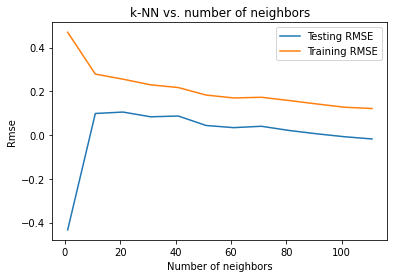

In [184]:
plt.title('k-NN vs. number of neighbors')
plt.plot(neighbors, np.mean(val_score, 1), label='Testing RMSE')
plt.plot(neighbors, np.mean(train_score, 1), label='Training RMSE')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Rmse')
plt.show()

Regression with KNN shows better performances. The best value seems to be around $k=15$.